In [1]:
import pandas as pd 
import numpy as np 

In [2]:
df = pd.read_csv('./data/train.csv')

In [3]:
df.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
df.shape

(5237980, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


Check na values

In [16]:
# in absolute value
for col in df.columns:
    print(f'{col}: {round(df[col].isna().sum())} missing values')

stock_id: 0 missing values
date_id: 0 missing values
seconds_in_bucket: 0 missing values
imbalance_size: 220 missing values
imbalance_buy_sell_flag: 0 missing values
reference_price: 220 missing values
matched_size: 220 missing values
far_price: 2894342 missing values
near_price: 2857180 missing values
bid_price: 220 missing values
bid_size: 0 missing values
ask_price: 220 missing values
ask_size: 0 missing values
wap: 220 missing values
target: 88 missing values
time_id: 0 missing values
row_id: 0 missing values


In [17]:
# in percentage 
for col in df.columns:
    print(f'{col}: {round(df[col].isna().sum()*100/df.shape[0], 5)}% of missing values')

stock_id: 0.0% of missing values
date_id: 0.0% of missing values
seconds_in_bucket: 0.0% of missing values
imbalance_size: 0.0042% of missing values
imbalance_buy_sell_flag: 0.0% of missing values
reference_price: 0.0042% of missing values
matched_size: 0.0042% of missing values
far_price: 55.25684% of missing values
near_price: 54.54736% of missing values
bid_price: 0.0042% of missing values
bid_size: 0.0% of missing values
ask_price: 0.0042% of missing values
ask_size: 0.0% of missing values
wap: 0.0042% of missing values
target: 0.00168% of missing values
time_id: 0.0% of missing values
row_id: 0.0% of missing values


far_price and near_price have a lot of missing values, let's check their correlation with the target value

In [18]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [22]:
df['far_price'][(~df['far_price'].isna()) & (df['far_price'] < 10)]

5730       1.000241
5731       0.981974
5732       1.000193
5733       1.003870
5734       1.007894
             ...   
5237975    0.999734
5237976    1.000129
5237977    0.995789
5237978    0.999210
5237979    1.000859
Name: far_price, Length: 2343599, dtype: float64

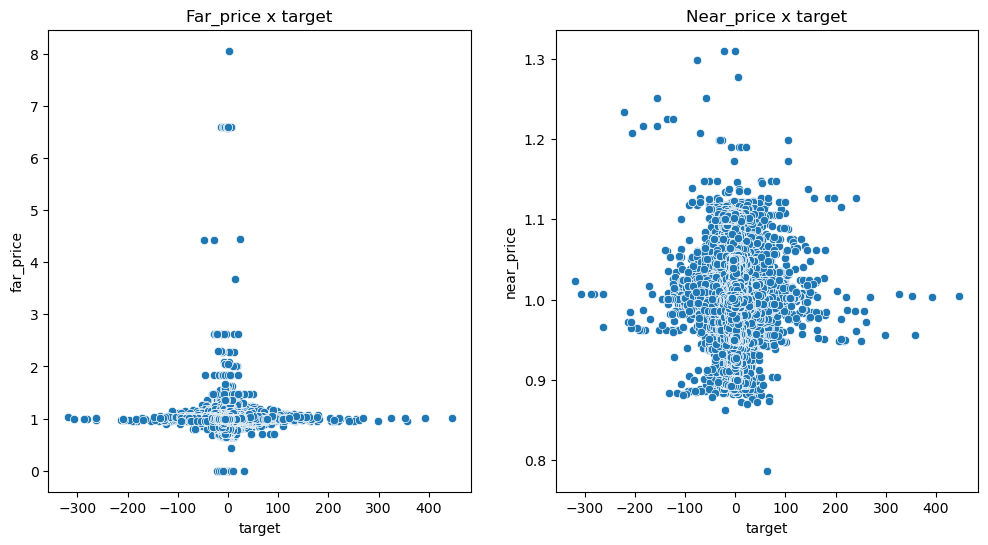

In [60]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

sns.scatterplot(x=df['target'][(~df['far_price'].isna()) & (df['far_price'] < 10)]\
                , y=df['far_price'][(~df['far_price'].isna()) & (df['far_price'] < 10)], ax=ax1)

sns.scatterplot(x=df['target'][(~df['near_price'].isna()) & (df['near_price'] < 10)]\
                , y=df['near_price'][(~df['near_price'].isna()) & (df['near_price'] < 10)], ax=ax2)

_ = ax1.set_title('Far_price x target')
_ = ax2.set_title('Near_price x target')

has no big correlation with the target, probably will remove later

In [54]:
lower_percentile = np.nanpercentile(df['target'], 2.5)
upper_percentile = np.nanpercentile(df['target'], 97.5)
upper_percentile

18.7397

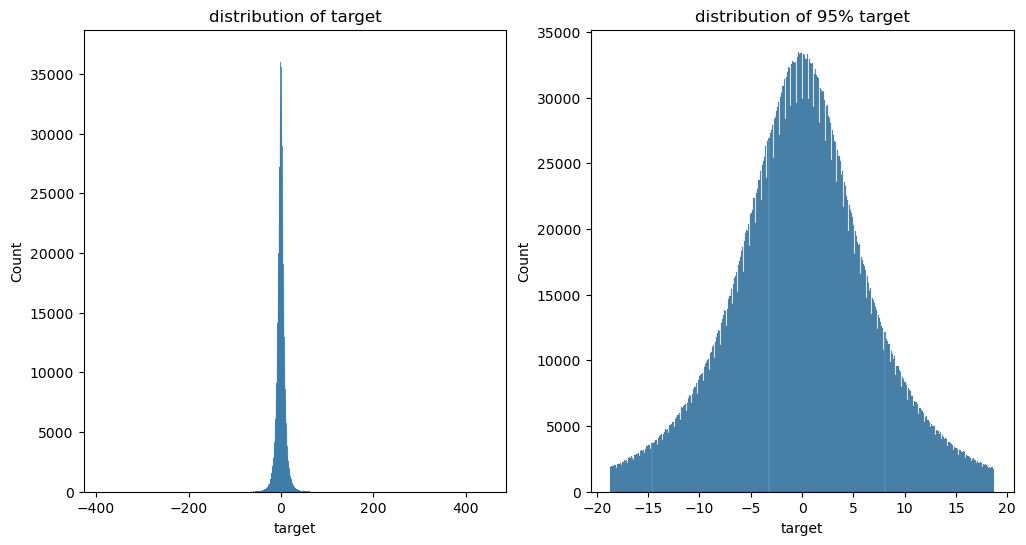

In [59]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

sns.histplot(x=df.target, ax=ax1)

# let's filter target by percentiles to better check distribution
lower_percentile = np.nanpercentile(df.target, 2.5)
upper_percentile = np.nanpercentile(df.target , 97.5)

filtered_target = df.query('target >= @lower_percentile and target <= @upper_percentile')

sns.histplot(x=filtered_target.target, ax=ax2)

_ = ax1.set_title('distribution of target')
_ = ax2.set_title('distribution of 95% target')


target is normaly distributed